$\textbf{x}\in\Omega$

$$\frac{\partial u}{\partial t} + \textbf{a}\cdot\nabla u= \nabla\cdot(\kappa\nabla u)$$

$$\int_\Omega\text{d}x~v\frac{\partial u}{\partial t} + v(\textbf{a}\cdot\nabla u) + \nabla v\cdot\kappa\nabla u - \int_{\partial\Omega}\text{d}s~v(\textbf{n}\cdot\kappa\nabla u)=0$$

$$\int_\Omega\text{d}x~v\frac{u^{n+1} - u^n}{\Delta t} + v(\textbf{a}^n\cdot\nabla\mathcal{D}_a(u)) + \nabla v\cdot\kappa\nabla\mathcal{D}_\kappa(u) - \int_{\partial\Omega}\text{d}s~v(\textbf{n}\cdot\kappa\nabla u)=0$$

$\textbf{x}\in\partial\Omega_D$ Dirichlet boundary condition

$$u = u_D$$

$\textbf{x}\in\partial\Omega_N=\partial\Omega/\partial\Omega_D$ Neumann boundary condition

$$\textbf{n}\cdot\kappa\nabla{u} = u_N$$

In [ ]:
import numpy as np
from ufl.core.expr import Expr
from ufl import Form, dx, inner, grad, TestFunction

from lucifex.mesh import interval_mesh
from lucifex.fdm import DT, CN, FiniteDifference, FunctionSeries, ConstantSeries
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import ibvp_solver, eval_solver
from lucifex.sim import integrate, Simulation
from lucifex.viz import plot_line, plot_twin_liplot_stacked_linesstack
from lucifex.utils import extremum


def advection_diffusion(
    u: FunctionSeries,
    dt: Constant,
    a: Function | Constant,
    k: Function | Constant | Expr,
    Dt_adv: FiniteDifference,
    Dt_diff: FiniteDifference,
) -> tuple[Form, Form]:
    v = TestFunction(u.function_space)
    Ft = v * DT(u, dt) * dx
    Fa = v * inner(a, grad(Dt_adv(u))) * dx
    Fd = inner(grad(v), k * grad(Dt_diff(u))) * dx
    return Ft, Fa, Fd

$$\Omega = [0, L_x]$$

$$\textbf{a}=x(L_x - x)\textbf{e}_x$$

$x=0$ and $x=L_x$ Neumann boundaries

$$\textbf{n}\cdot\kappa\nabla u=0$$

In [2]:
def advection_simulation(
    Dt_adv: FiniteDifference,
    Dt_diff: FiniteDifference,
) -> Simulation:
    order = max((Dt_adv.order, Dt_diff.order, 1))

    Lx = 2.0
    mesh = interval_mesh(Lx, 200)

    t = ConstantSeries(mesh, name='t', ics=0.0)
    dt = Constant(mesh, 0.01, name='dt')
    a = Function((mesh, 'P', 1, 1), name='a')
    a.interpolate(lambda x: (x[0] * (Lx - x[0]), ))
    k = Constant(mesh, 0.1, name='k')
    u = FunctionSeries((mesh, 'P', 1), name='u', order=order, store=1)

    ics = lambda x: np.exp(-(x[0] - 0.2 * Lx)**2 / (0.001 * Lx))
    u_solver = ibvp_solver(advection_diffusion, ics)(u, dt, a, k, Dt_adv, Dt_diff)

    uMinMax = ConstantSeries(mesh, name='uMinMax', shape=(2,), store=1)
    uMinMax_solver = eval_solver(uMinMax, extremum)(u[0])

    solvers = [u_solver, uMinMax_solver]

    return Simulation(solvers, t, dt)

simulation = advection_simulation(CN, CN)
n_stop = 50
integrate(simulation, n_stop)

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x$', ylabel='$u$'>)

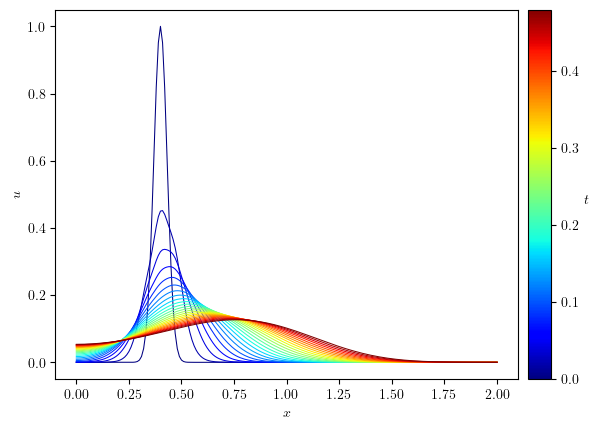

In [3]:
u = simulation['u']
slc = slice(0, None, 2)
legend_labels=(min(u.time_series[slc]), max(u.time_series[slc]))
plot_line(u.series[slc], legend_labels, 't', cycler='jet', x_label='x', y_label=u.name)

(<Figure size 640x480 with 2 Axes>,
 [<Axes: ylabel='$\\min(u)$'>, <Axes: xlabel='$t$', ylabel='$\\max(u)$'>])

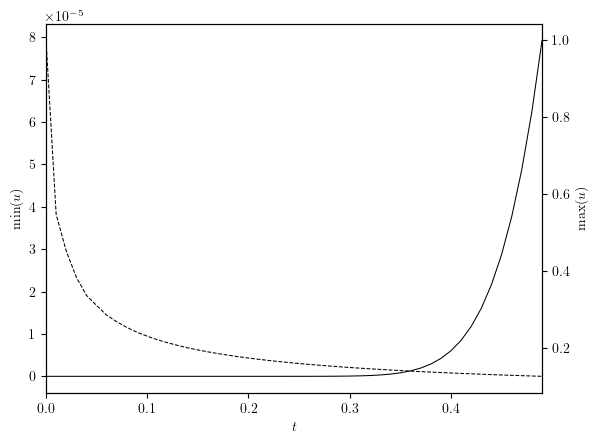

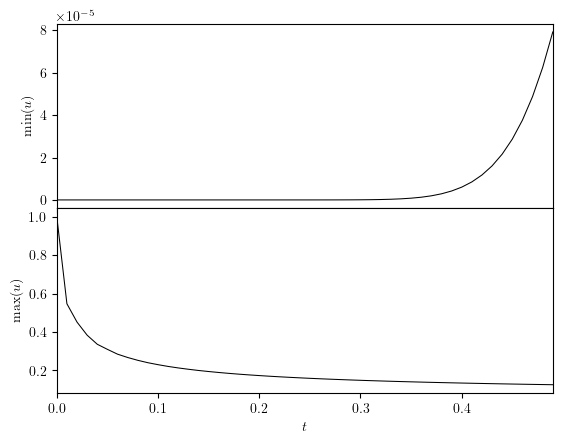

: 

In [ ]:
uMinMax = simulation['uMinMax']
uMin = [i[0] for i in uMinMax.value_series]
uMax = [i[1] for i in uMinMax.value_series]

y_labels = ('\min(u)', '\max(u)')

plot_twin_lines(
    uMinMax.time_series,
    (uMin, uMax),
    y_labels,
    x_label='t',
)

plot_stacked_lines(
    [(uMinMax.time_series, uMin), (uMinMax.time_series, uMax)],
    't',
    y_labels,
)